<a href="https://colab.research.google.com/github/ThomasCEG/PSL-Week---THOMAS/blob/main/PSL_WEEK_TP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PSL WEEK - DL

*Notebook prepared by Arthur Thomas based on lab work of Mathieu Blondel, November 2022.*


*The accompanying slides are available [here](https://www.mblondel.org/teaching/autodiff-2020.pdf).*



## Automatic differentiation 

In this first part of the lab work, we are going to implement reverse differentiation (a.k.a. backpropagation) for a feedforward network (that is, the composition of a **sequence** or **chain** of functions).


### Numerical differentiation utilities

In this section, I define utility functions for computing Jacobians, Jacobian-vector products (VJPs), and vector Jacobian products (VJPs). You will need to use them to check the correctness of your implementations.

In [ ]:
import numpy as np

def num_jvp(f, x, v, eps=1e-6):
  """
  Args:
    f: a function returning an array.
    x: an array.
    v: an array (same shape as x).

  Returns:
    numerical_jvp
  """
  if not np.array_equal(x.shape, v.shape):
    raise ValueError("x and v should have the same shape.")

  return (f(x + eps * v) - f(x - eps * v)) / (2 * eps)

def num_jacobian(f, x, eps=1e-6):
  """
  Args:
    f: a function returning an array.
    x: an array (only 1d and 2d arrays supported).

  Returns:
    numerical_jacobian
  """
  def e(i):
    ret = np.zeros_like(x)
    ret[i] = 1
    return ret

  def E(i, j):
    ret = np.zeros_like(x)
    ret[i, j] = 1
    return ret

  if len(x.shape) == 1:
    return np.array([num_jvp(f, x, e(i), eps=eps) for i in range(len(x))]).T
  elif len(x.shape) == 2:
    return np.array([[num_jvp(f, x, E(i, j), eps=eps) \
                     for i in range(x.shape[0])] \
                     for j in range(x.shape[1])]).T
  else:
    raise NotImplementedError

def num_vjp(f, x, u, eps=1e-6):
  """
  Args:
    f: a function returning an array.
    x: an array (only 1d and 2d arrays supported).

  Returns:
    numerical_vjp
  """
  J = num_jacobian(f, x, eps=eps)
  if len(J.shape) == 2:
    return J.T.dot(u)
  elif len(J.shape) == 3:
    shape = J.shape[1:]
    J = J.reshape(J.shape[0], -1)
    return u.dot(J).reshape(shape)
  else:
    raise NotImplementedError


### Vector Jacobian products (VJPs) for basic primitives

In this section, we are going to define VJPs for basic primitives

In [ ]:
def dot(x, W):
  return np.dot(W, x)

def dot_make_vjp(x, W):
  def vjp(u):
    return W.T.dot(u), np.outer(u, x)
  return vjp

dot.make_vjp = dot_make_vjp

def squared_loss(y_pred, y):
  # The code requires every output to be an array.
  return np.array([0.5 * np.sum((y - y_pred) ** 2)])

def squared_loss_make_vjp(y_pred, y):
  diff = y_pred - y

  def vjp(u):
    return diff * u, -diff * u

  return vjp

squared_loss.make_vjp = squared_loss_make_vjp

# Cross-entropy loss
def cross_entropy_loss(y_pred, y):
    cross_entropy = -y * np.log(y_pred) - (1 - y)*np.log(1 - y_pred)
    return np.array([cross_entropy])

def add(a, b):
  return a + b

def add_make_vjp(a, b):
  
  gprime = np.ones(len(a))

  def vjp(u):
    return u * gprime, u * gprime

  return vjp

add.make_vjp = add_make_vjp

def mul(a, b):
  return a * b

def mul_make_vjp(a, b):
  gprime_a = b
  gprime_b = a

  def vjp(u):
    return u * gprime_a, u * gprime_b

  return vjp

mul.make_vjp = mul_make_vjp

def exp(x):
  return np.exp(x)

def exp_make_vjp(x):
  gprime = exp(x)

  def vjp(u):
    return u * gprime,

  return vjp

exp.make_vjp = exp_make_vjp

def sqrt(x):
  return np.sqrt(x)

def sqrt_make_vjp(x):
  gprime = 1. / (2 * sqrt(x))

  def vjp(u):
    return u * gprime,

  return vjp

sqrt.make_vjp = sqrt_make_vjp

#### **Exercise 1** 

Look at the "exp", "sqrt" and "squared_loss" examples above and define the primitive and its associated VJP for the sigmoid function: `sigmoid(x) = 1/(1+ np.exp(-x))`, for the hyperbolic tangent function: `tanh(x) = (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))` and cross entropy loss: `-y * np.log(y_pred) - (1 - y)*np.log(1 - y_pred)`. Check the correctness of your implementation using the `num_vjp` utility function.

In [ ]:
rng = np.random.RandomState(0)
x_test = rng.randn(5)
u_test = rng.randn(5)

# Your implementation



In [ ]:
# Check the correctness of your vjp using num_vjp:
#print(num_vjp(sigmoid, x_test, u_test))
#print(num_vjp(tanh, x_test, u_test))

In [ ]:
# simulate relevant values for cross_entropy
rng = np.random.RandomState(0)
y_pred_test = rng.rand(5)
y_test = rng.rand(5)
u_test = rng.randn(5)

### Reverse differentiation of feedforward networks

Feedforward networks use a sequence of functions. The functions can either be of the form `func(x, param)` if the function has learnable parameters (e.g., `dot(x, W)`) or `func(x)` if the function doesn't have learnable parameters (e.g., `exp(x)`). 

We represent a feedforward network using a list of functions and a list of parameters. Let us create a small utility function for creating such a network.

In [ ]:
def create_feed_forward(n, y, seed=0):
  rng = np.random.RandomState(seed)

  funcs = [
    dot,
    add,
    tanh,
    dot,
    add,
    sigmoid,
    cross_entropy_loss,
  ]

  params = [
        rng.randn(3, n), # w1
        rng.randn(3), # b1
        None,  
        rng.randn(1,3),  # w2
        rng.randn(), #b2
        None,  
        y
  ]

  return funcs, params

Next, let us create a small utility function for correctly calling each function, depending on whether it has 1 or 2 arguments.

In [ ]:
def call_func(x, func, param):
  """Make sure the function is called with the correct number of arguments."""

  if param is None:
    # Unary function
    return func(x)
  else:
    # Binary function
    return func(x, param)

#### **Exercise 2**  
Implement the following function for evaluating the feedforward network. Check that the returned value is correct.

In [ ]:
def evaluate_chain(x, funcs, params, return_all=False):
  """
  Evaluate a chain of functions.

  Args:
    x: initial input to the chain.
    funcs: a list of functions of the form func(x) or func(x, param).
    params: a list of parameters, with len(params) = len(funcs).
            If a function doesn't have parameters, use None.
    return_all: whether to return all intermediate values or only the last one.

  Returns:
    value (return_all == False) or values (return_all=True)
  """
  if len(funcs) != len(params):
    raise ValueError("len(funcs) and len(params) should be equal.")

  if return_all:
    return
  else:
    return


In [ ]:
rng = np.random.RandomState(0)
x = rng.randn(2)
y = 0.7

funcs, params = create_feed_forward(n=len(x), y=y, seed=0)
W1,B1,_,W2,B2,_,y = params

value1=evaluate_chain(x, funcs, params,True)
value1

In [ ]:
# Make sure that `evaluate_chain(x, funcs, params)` returns the same value as
# a manual implementaton:
#x1 = dot(x, W1)
#print(x1)
#x2 = add(x1,B1)
#print(x2)
#x3 = tanh(x2)
#print(x3)
#x4 = dot(x3,W2)
#print(x4)
#add_make_vjp(x4,B2)
#x5 = add(x4, B2)
#print(x5)
#x6=sigmoid(x5)
#print(x6)
#value = cross_entropy_loss(x6, y)
#value

#### **Exercise 3**
Reusing the previous function with `return_all=True`, implement the following function that returns both the network value and the Jacobian w.r.t. `x`. Check correctness of the Jacobian using `num_jacobian`.

In [ ]:
def call_vjp(x, func, param, u):
  """Make sure the vjp is called with the correct number of arguments."""
  if param is None:
    vjp = func.make_vjp(x)
    vjp_x, = vjp(u)
    vjp_param = None
  else:
    vjp = func.make_vjp(x, param)
    vjp_x, vjp_param = vjp(u)
  return vjp_x, vjp_param

In [ ]:
def reverse_diff_chain(x, funcs, params):
  """
  Reverse-mode differentiation of a chain of computations.

  Args:
    x: initial input to the chain.
    funcs: a list of functions of the form func(x) or func(x, param).
    params: a list of parameters, with len(params) = len(funcs).
            If a function doesn't have parameters, use None.

  Returns:
    value, Jacobian w.r.t. x
  """
  # Evaluate the feedforward model and store intermediate computations,
  # as they will be needed during the backward pass.
  xs = evaluate_chain(x, funcs, params, return_all=True)

  m = xs[-1].shape[0]  # Output size
  K = len(funcs)  # Number of functions.

  # We need a list as the shape of U can change.
  U = list(np.eye(m))

  for k in reversed(range(K)):
    # Implement backward differentiation here

  return xs[-1], np.array(U)

IndentationError: ignored

In [ ]:
#value, jac = reverse_diff_chain(x, funcs, params)
#print(jac)
#print(value)

In [ ]:
# Check correctness of Jacobian using `num_jacobian`.
def f(x):
  return evaluate_chain(x, funcs, params)
# # num_jacobian only accepts functions of one argument.
#num_jac = num_jacobian(f, x)
#num_jac

#### **Exercise 4**

Modify the above function to also return the Jacobians w.r.t. W1, W3, W5. Check correctness using `num_jacobian`.

In [ ]:
value, jac, W = reverse_diff_chain_2(x, funcs, params)
#print(jac)
#print(W)
#print(value)

#### Exercise 5

Validate preceding results with JAX framework

In [ ]:
import jax.numpy as jnp
from jax import grad

def jnp_sigmoid(x):
    return 1 / (1 + jnp.exp(-x))

# Computes our network's output
def net(params, x):
    w1, b1, w2, b2 = params
    hidden = jnp.tanh(jnp.dot(w1, x) + b1)
    return jnp_sigmoid(jnp.dot(w2, hidden) + b2)

# Cross-entropy loss
def loss(params, x, y):
    out = net(params, x)
    cross_entropy = -y * jnp.log(out) - (1 - y)*jnp.log(1 - out)
    return cross_entropy

# compute loss gradient
loss_grad = grad(loss)

## Training NNET

### Prepare dataset

In [ ]:
import random
import itertools

#### **Exercise 6** 
We propose to begin with the classic Moons simulated dataset, to have two input features and as target two possible classes. You may start with this dataset, but you have to either (a) simulate a new dataset, (b) load some appropriate data to use (any ML repository will do).

In [ ]:
# some imports
from sklearn.datasets import *
import pandas as pd

In [ ]:
# generate 2d classification dataset
X, y = make_moons(n_samples=100, noise=0.1)

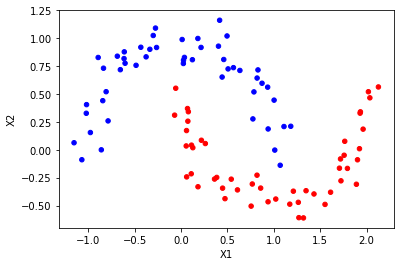

In [ ]:
# create proper dataframe with column names
m = pd.DataFrame([X[:,0], X[:,1], y]).T
m.columns = ["X1", "X2", "Class"]

# nice plot
col = m.Class.map({0:'b', 1:'r'})
m.plot(x = "X1", y = "X2", kind = 'scatter', color = col)

### Training

#### **Exercise 7**

Fill in the code below in order to train the neural network on the simulated training dataset. Take some time to think about different stopping criterions.

In [ ]:
# Sigmoid nonlinearity
def sigmoid(x):
    return 1 / (1 + jnp.exp(-x))

# Computes our network's output
def net(params, x):
    w1, b1, w2, b2 = params
    hidden = jnp.tanh(jnp.dot(w1, x) + b1)
    return sigmoid(jnp.dot(w2, hidden) + b2)

# Cross-entropy loss
def loss(params, x, y):
    out = net(params, x)
    cross_entropy = -y * jnp.log(out) - (1 - y)*jnp.log(1 - out)
    return cross_entropy

def initial_params():
    return [
        np.random.randn(3, 2),  # w1
        np.random.randn(3),  # b1
        np.random.randn(3),  # w2
        np.random.randn(),  #b2
    ]

In [ ]:
## Training the neural network
learning_rate = 0.1
for n in itertools.count():
    # select observations
    sel = 
    # X selected
    x_sel = 
    # Y selected
    y_sel = 
    # compute the gradient
    gradient = 
    # update neural network parameter via gradient descent rule
    params = [param - learning_rate * g
              for param, g in zip(params, gradient)]
    # check stopping criterion
    some_condition = 
    if some_condition:
      break

### Testing

#### **Exercise 8**

Analyse the performance of the neural network (ideally on training & testing set) and the convergence of its parameters throughout iterations

### Visualization

#### **Exercise 9**

Plot the decision boundary computed by the neural network

In [ ]:
# using np.meshgrid, plt.contourf, plt.scatter

#### **Exercise 10**

Using GraphViz to represent YOUR neural network

In [ ]:
from graphviz import Digraph


def f(x):
  return ('(' + str(round(x, 1)) + ')')
 
dot = Digraph(comment='The Round Table')
dot.attr(rankdir='LR')

# inputs
dot.node('X1', 'Input 1\nX1')
dot.node('X2', 'Input 2\nX2')

# hidden layer
dot.node('N11', 'Neuron N[11]\n sigmoid(' + f(params[1][0]) + ' + ' + f(params[0][0,0]) + ' * X1 + ' + f(params[0][0,1]) + ' * X2)')
dot.node('N12', 'Neuron N[12]\n sigmoid(' + f(params[1][1]) + ' + ' + f(params[0][1,0]) + ' * X1 + ' + f(params[0][1,1]) + ' * X2)')
dot.node('N13', 'Neuron N[13]\n sigmoid(' + f(params[1][2]) + ' + ' + f(params[0][2,0]) + ' * X1 + ' + f(params[0][2,1]) + ' * X2)')

# edges between inputs and hidden layer
dot.edge('X1', 'N11')
dot.edge('X1', 'N12')
dot.edge('X1', 'N13')
dot.edge('X2', 'N11')
dot.edge('X2', 'N12')
dot.edge('X2', 'N13')

# output
dot.node('O', 'Y^\n sigmoid(' + f(params[3]) + ' + ' + f(params[2][0]) + ' * N[11] \n+ ' + f(params[2][1]) + ' * N[12] + ' + f(params[2][2]) + ' * N[13])')

# edges between hidden layer and output
dot.edge('N11', 'O')
dot.edge('N12', 'O')
dot.edge('N13', 'O')

#
print(dot.source)